In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [369]:
#other useful imports we've seen before

import h5py
import numpy as np
import math

## Finding some interesting neurons 

In [225]:
#ok let's load the data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [483]:
#useful utility function for plotting HDF5 dimension labels
def dimnames(dataset):
    dims = dataset.dims  #get the dimension object
    dimlist = [x.label for x in dims.keys()]  #get the label attribute
    dimlist = map(str, dimlist)  #cast everything to string instead of "unicode" ... complicated rathole ... not strictly necessary
    return dimlist

In [226]:
#let's get the IT neural data -- time and trial averaged
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged']
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

#... and remind ourselves of the tensor shape
print('Shape:', IT_Neural_Data.shape)
print('Dimensions:', dimnames(Neural_Data))
#right, 5760 images and 168 neurons

('Shape:', (5760, 168))
('Dimensions:', ['image', 'neuron'])


In [485]:
#ok just like last time it was useful to sort by category 
#so this code is a copy from last time
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 
objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}
objects_sorted_by_categories = np.concatenate([objects_by_category[c] for c in unique_categories])


In [487]:
#Now, we're interested in looking at some responses in closer detail
#let's plot some neuron's responses, averaged over all images of a given object
#on a per variation level basis
var_level = Ventral_Dataset['image_meta']['variation_level'][:]
unique_var_levels = np.unique(var_level)

sorted_IT_Neural_Data_means = np.array([IT_Neural_Data[(var_level == v) & (objects == o)].mean(0)
                                        for o in objects_sorted_by_categories
                                        for v in unique_var_levels ])

(-0.36312854, 0.3914291)

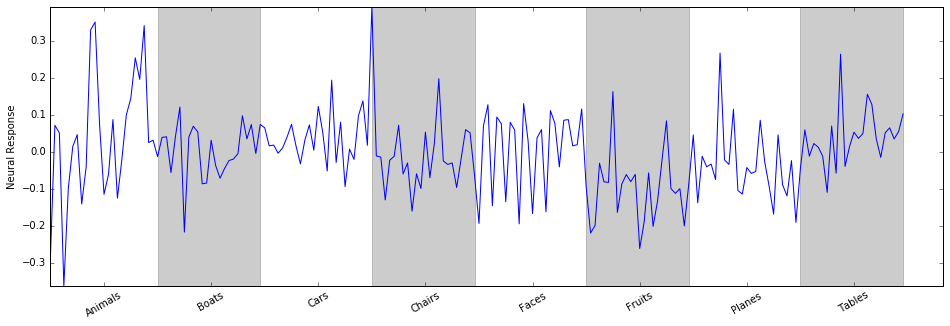

In [489]:
plt.figure(figsize=(16, 5))
neuron_ind = 0
neuron_i_data = sorted_IT_Neural_Data_means[:, neuron_ind]
minval = neuron_i_data.min()
maxval = neuron_i_data.max()
plt.plot(neuron_i_data)
plt.fill_between(np.arange(192), minval, maxval, 
                 where=(np.arange(192) / 24) % 2, color='k', alpha=0.2)
plt.xticks(np.arange(0, 192, 24) + 12, unique_categories, rotation=30);
plt.ylabel('Neural Response')
plt.ylim(minval, maxval)

#ok, well the 0th (first) neuron doesn't look that easy to interpret .... 

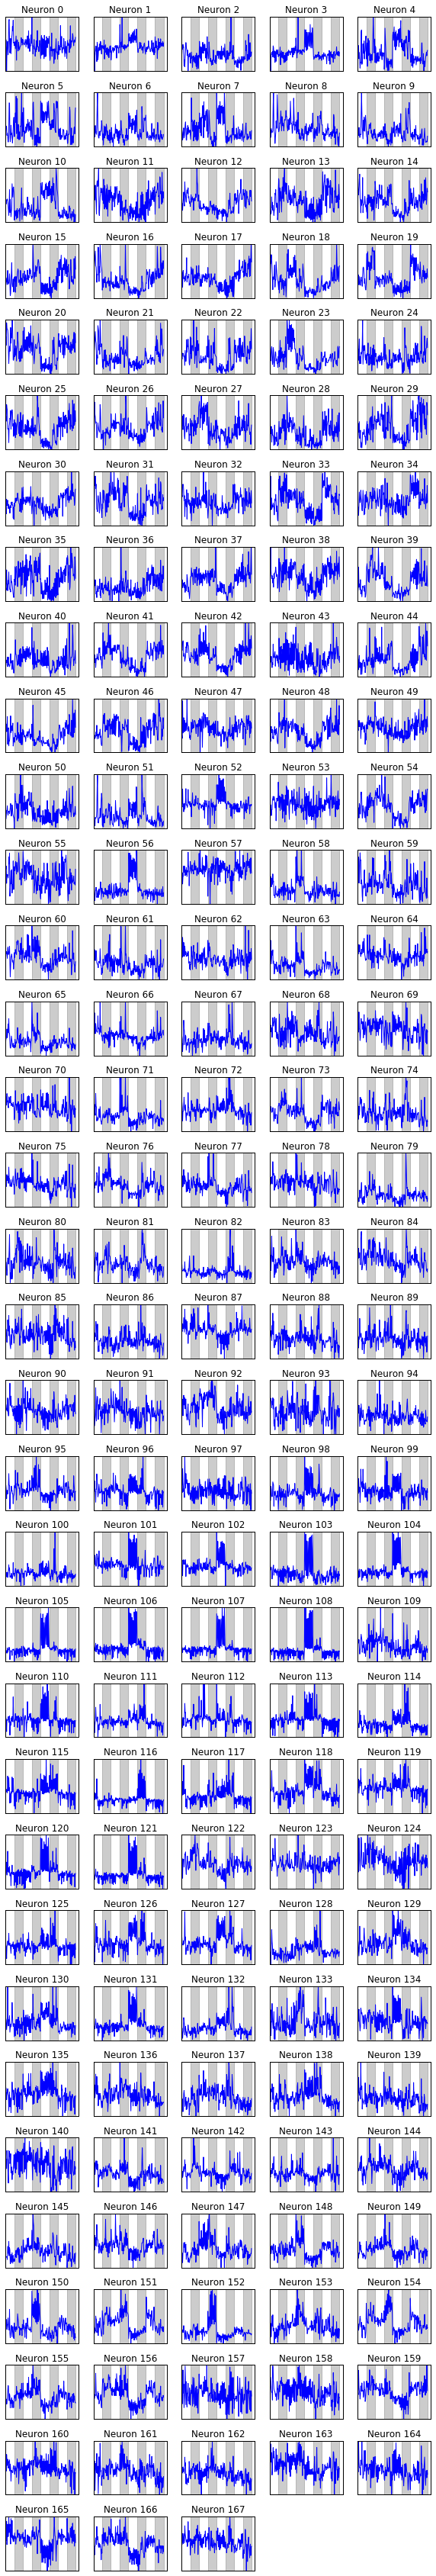

In [229]:
#but wait, let's plot *all* the IT neurons responses
plt.figure(figsize=(10, 60))
for neuron_ind in range(168):
    plt.subplot(34, 5, neuron_ind + 1)
    neuron_i_data = sorted_IT_Neural_Data_means[:, neuron_ind]
    minval = neuron_i_data.min()
    maxval = neuron_i_data.max()
    plt.plot(neuron_i_data)
    plt.fill_between(np.arange(192), minval, maxval, 
                     where=(np.arange(192) / 24) % 2, color='k', alpha=0.2)
    plt.xticks([]); plt.yticks([])
    plt.title('Neuron %d' % neuron_ind)
    plt.ylim(minval, maxval)
plt.subplots_adjust(hspace=0.4)

#hey what's going on with neurons 101-108 --- the seem to really like Faces!

(-0.27882752, 0.91493052)

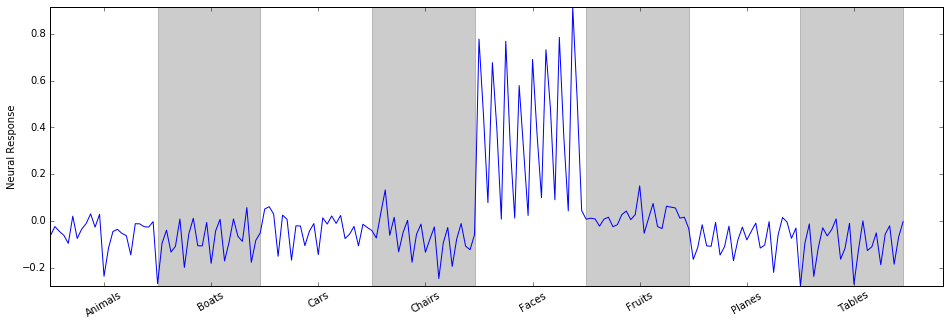

In [230]:
#let's look at one of these more closely.

neuron_ind = 105
plt.figure(figsize=(16, 5))
neuron_i_data = sorted_IT_Neural_Data_means[:, neuron_ind]
minval = neuron_i_data.min()
maxval = neuron_i_data.max()
plt.plot(neuron_i_data)
plt.fill_between(np.arange(192), minval, maxval, 
                 where=(np.arange(192) / 24) % 2, color='k', alpha=0.2)
plt.xticks(np.arange(0, 192, 24) + 12, unique_categories, rotation=30);
plt.ylabel('Neural Response')
plt.ylim(minval, maxval)

#remember -- sorted by category and then by variation level 
#there are 8 objects per category and 3 variation levels
#so that means each category block below has 24 points
#what we're the neuron response well to faces at low & medium (the first 
#and second point in each little group of 3 in the faces block)
#but it is much less responsive to high variation faces (the third point in each group of 3)

## Pairwise Reliability Analysis

In [284]:
#Let's look at the data 
by_trial_IT_Neural_Data_objmeans_sorted_by_category = {}
for vl in unique_var_levels:
    level_number = vl[-1]
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, IT_NEURONS]
    objects_at_var_level = objects[var_level == vl]
    arr1 = np.array([arr[:, objects_at_var_level == o].mean(1) for o in objects_sorted_by_categories])
    by_trial_IT_Neural_Data_objmeans_sorted_by_category[vl] = arr1


In [286]:
#so for each variation level, this dictionary has stuff of shape 
#(num_objects, num_trials_at_this_variation_level, num_IT_neurons)
by_trial_IT_Neural_Data_objmeans_sorted_by_category['V0'].shape

(64, 28, 168)

In [334]:
def plot_various_trial_analyses(neuron_ind, var_level):
    plt.figure(figsize=(16, 5))
    
    #the first thing we want to do is just plot the data average
    #so first get the data for all trials
    neuron_i_data_by_trial = by_trial_IT_Neural_Data_objmeans_sorted_by_category[var_level][:, :, neuron_ind]
    #now take the mean over the second dimension -- the trial dimension
    neuron_i_data_trial_mean = neuron_i_data_by_trial.mean(1)
    #for convenience, let's compute the min and max values of the neural response
    minval = neuron_i_data_trial_mean.min()
    maxval = neuron_i_data_trial_mean.max()
    #now let's plot the responses across objects
    plt.plot(neuron_i_data_trial_mean)
    #and block stuff to make the categories easier to see
    plt.fill_between(np.arange(64), minval, maxval, 
                     where=(np.arange(64) / 8) % 2, color='k', alpha=0.2)
    plt.xticks(np.arange(0, 64, 8) + 4, unique_categories, rotation=30);
    plt.ylabel('Neural Response of neuron %d' % neuron_ind)
    plt.ylim(minval, maxval)
    plt.xlabel('Responses for Variation %s images' % var_level)

    #now let's look at two trials -- the first and 6th ones, for example 
    t1 = 0; t2 = 5
    t1_data = neuron_i_data_by_trial[:, t1]
    t2_data = neuron_i_data_by_trial[:, t2]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t1_data)
    plt.xticks(np.arange(0, 64, 8), unique_categories, rotation=30);
    plt.title('Neuron %d, trial %d, var %s' % (neuron_ind, t1, var_level))
    plt.subplot(1, 2, 2)
    plt.plot(t2_data)
    plt.xticks(np.arange(0, 64, 8), unique_categories, rotation=30);
    plt.title('Neuron %d, trial %d, var %s' % (neuron_ind, t2, var_level))

    #let's do a scatter plot of the responses to one trial vs the other
    plt.figure()
    plt.scatter(t1_data, t2_data)
    plt.xlabel('responses of neuron %d, trial %d, %s'% (neuron_ind, t1, var_level))
    plt.ylabel('responses of neuron %d, trial %d, %s'% (neuron_ind, t2, var_level))

    #how correlated are they exactly between trials? let's use pearson correlation
    #from the scipy.stats package (lots of other stats coded there too)
    import scipy.stats as stats
    rval = stats.pearsonr(t1_data, t2_data)[0]
    plt.title('Correlation for varlevel %s images = %.3f' % (var_level, rval))

    #in fact, let's have a look at the correlation for all pairs of trials 
    fig = plt.figure(figsize = (7, 7))
    #the numpy corrcoef function basically gets the pairwise pearson correlation efficiently
    corrs = np.corrcoef(neuron_i_data_by_trial.T)
    #now let's plot the matrix of correlations using the matshow function
    plt.colorbar(fig.gca().matshow(corrs))
    plt.xlabel('trials of neuron %d' % neuron_ind)
    plt.ylabel('trials of neuron %d' % neuron_ind)
    plt.title('Between-trial correlations for varlevel %s' % var_level)


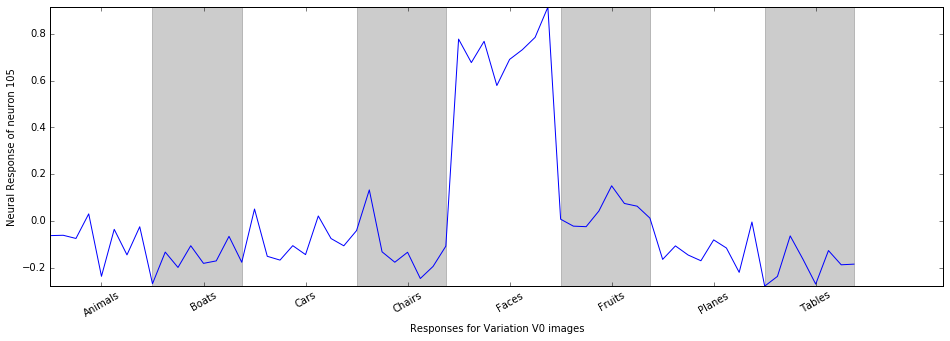

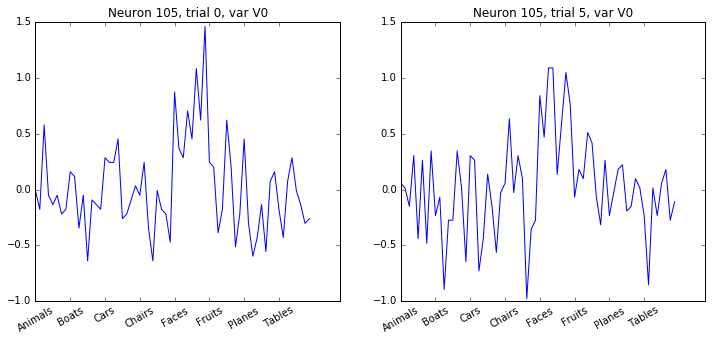

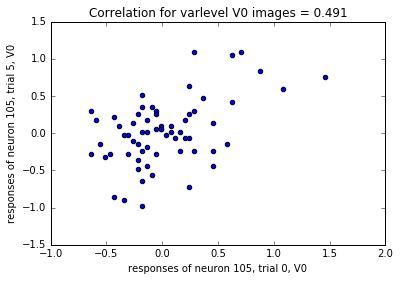

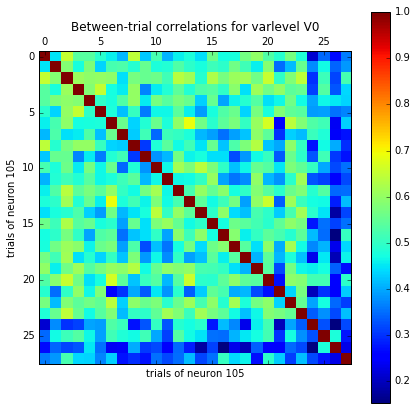

In [335]:
#ok let's use our analysis tool for Variation 0 images of neuron 105
plot_various_trial_analyses(105, 'V0')
#basically we find that the neuron definitely likes faces and is pretty correlated between trials  
#at this variation level

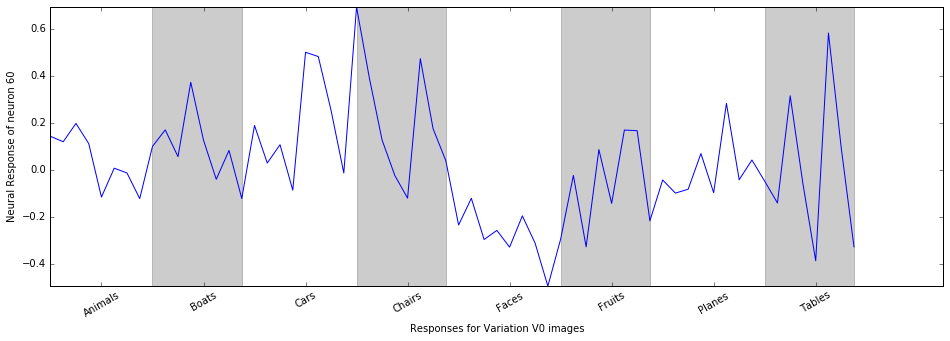

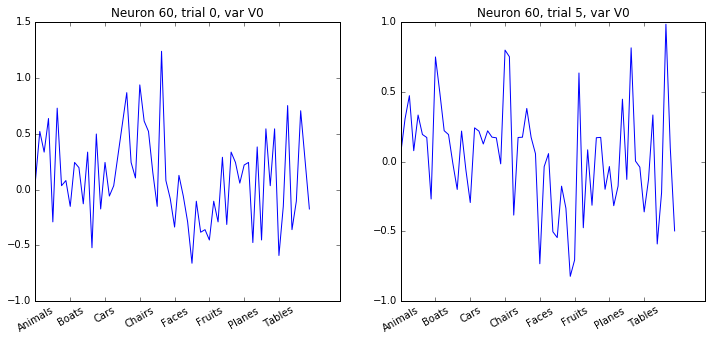

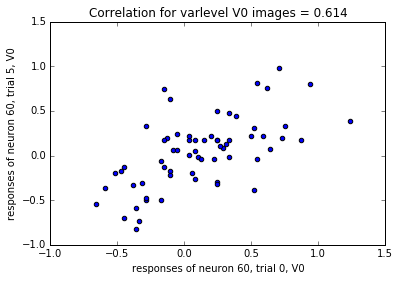

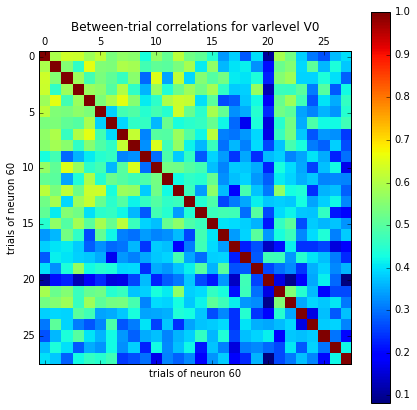

In [336]:
#neuron 60 has a more complex pattern -- maybe it's sorta anti-faces
plot_various_trial_analyses(60, 'V0')
#but also quite self-consistent between trials

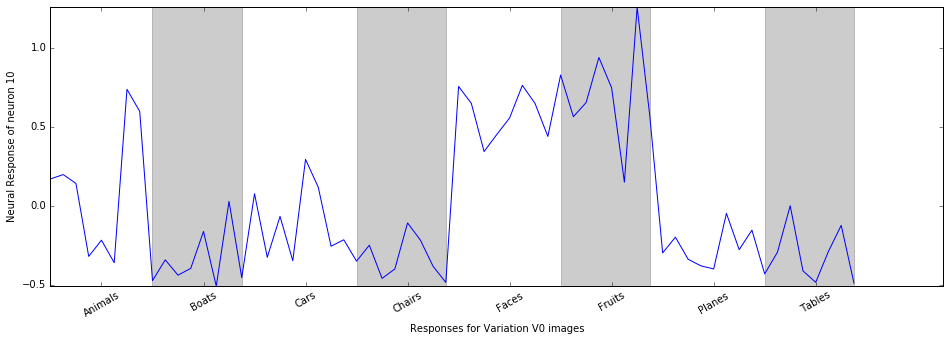

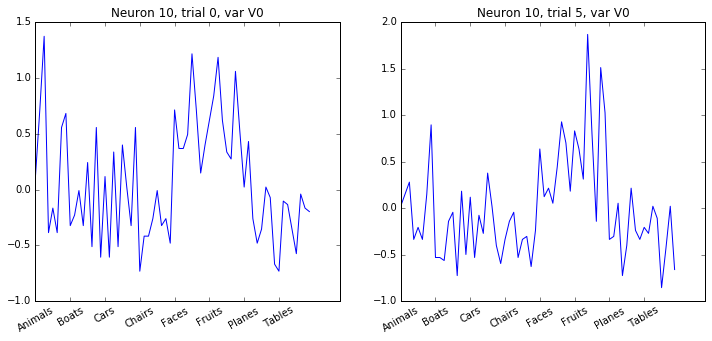

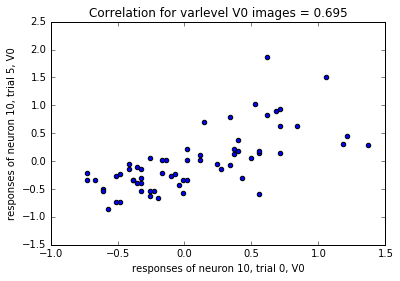

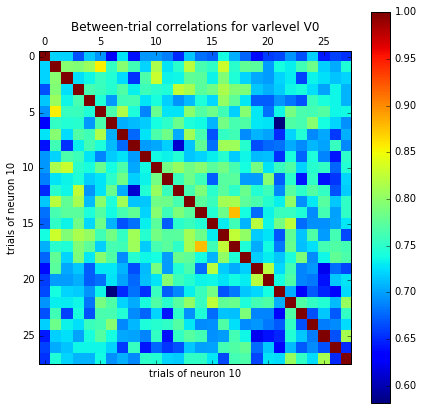

In [337]:
#perhaps neuron 10 is a "round thing" detector?  
plot_various_trial_analyses(10, 'V0')

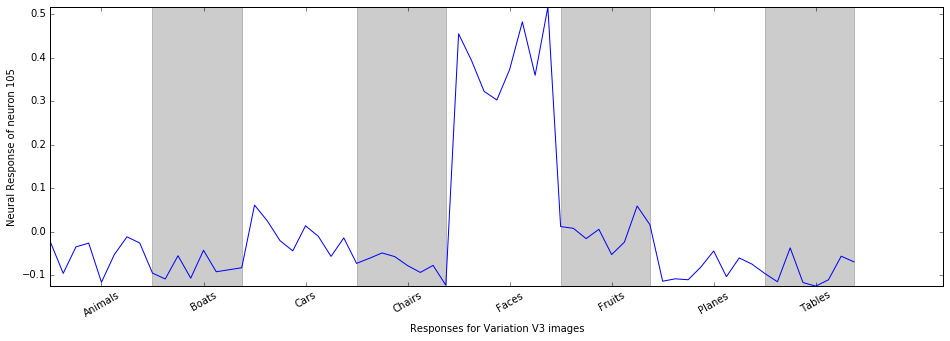

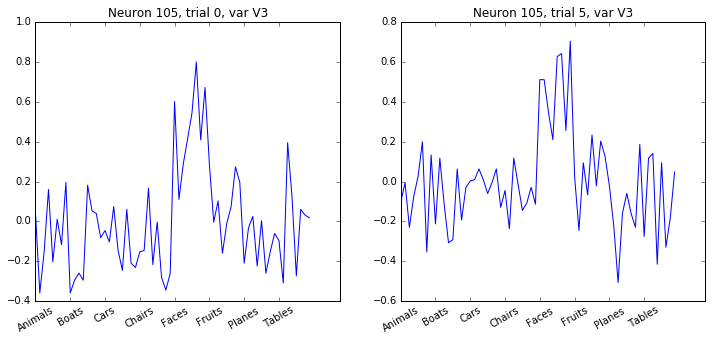

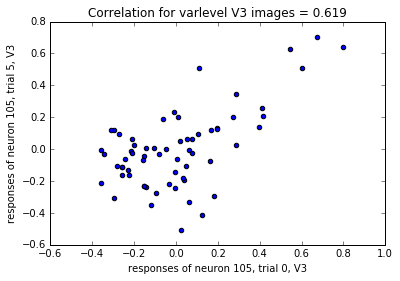

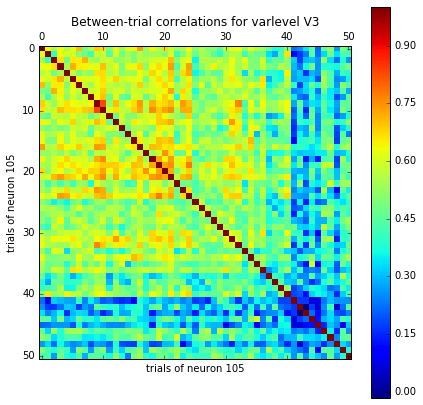

In [338]:
#neuron 105 is still pretty consistently face-liking at medium variation
plot_various_trial_analyses(105, 'V3')

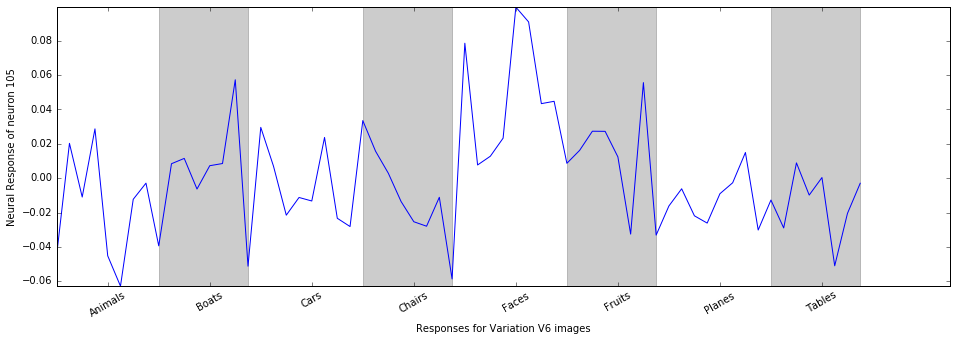

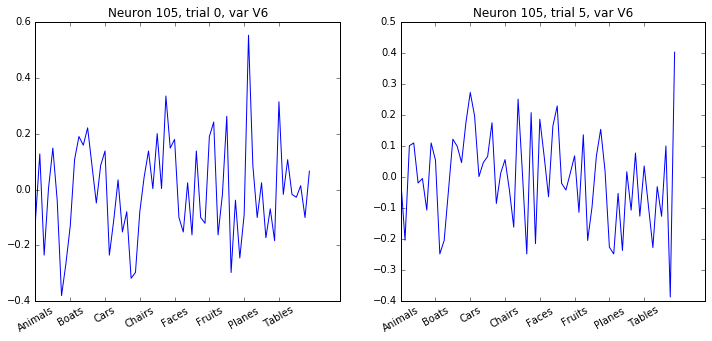

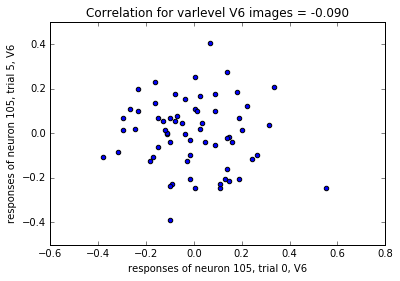

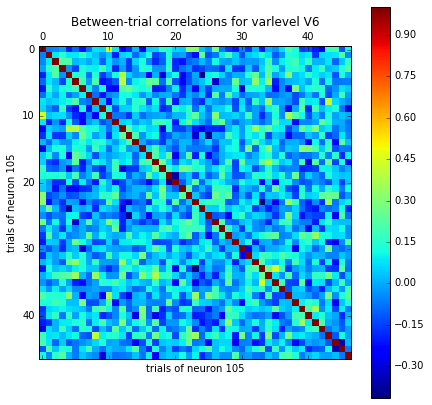

In [339]:
#but things get much murkier at high variation 
plot_various_trial_analyses(105, 'V6')

In [490]:
#this makes us curious to look at standard deviations of responses across trials
def plot_trial_avg_data_with_stds(neuron_ind, var_level):
    
    neuron_i_data_by_trial = by_trial_IT_Neural_Data_objmeans_sorted_by_category[var_level][:, :, neuron_ind]
    neuron_i_data_trial_mean = neuron_i_data_by_trial.mean(1)
    neuron_i_data_trial_std = neuron_i_data_by_trial.std(1)
    minval = neuron_i_data_trial_mean.min()
    maxval = neuron_i_data_trial_mean.max()
    plt.plot(neuron_i_data_trial_mean)
    plt.fill_between(np.arange(64), minval, maxval, 
                     where=(np.arange(64) / 8) % 2, color='k', alpha=0.2)

    plt.fill_between(np.arange(64), 
                     neuron_i_data_trial_mean - neuron_i_data_trial_std,
                     neuron_i_data_trial_mean + neuron_i_data_trial_std,
                     color='b', alpha=0.2)

    plt.xticks(np.arange(0, 64, 8) + 4, unique_categories, rotation=30);
    plt.ylabel('Neural Responses')
    plt.ylim(minval, maxval)
    plt.title('Responses for neuron %d Variation %s images' % (neuron_ind, var_level))
    plt.xlim(0, 64)

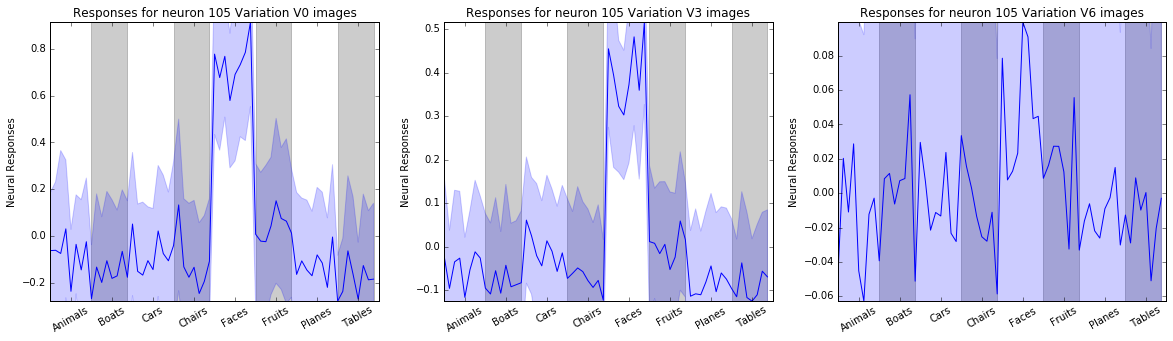

In [342]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plot_trial_avg_data_with_stds(105, 'V0')
plt.subplot(1, 3, 2)
plot_trial_avg_data_with_stds(105, 'V3')
plt.subplot(1, 3, 3)
plot_trial_avg_data_with_stds(105, 'V6')

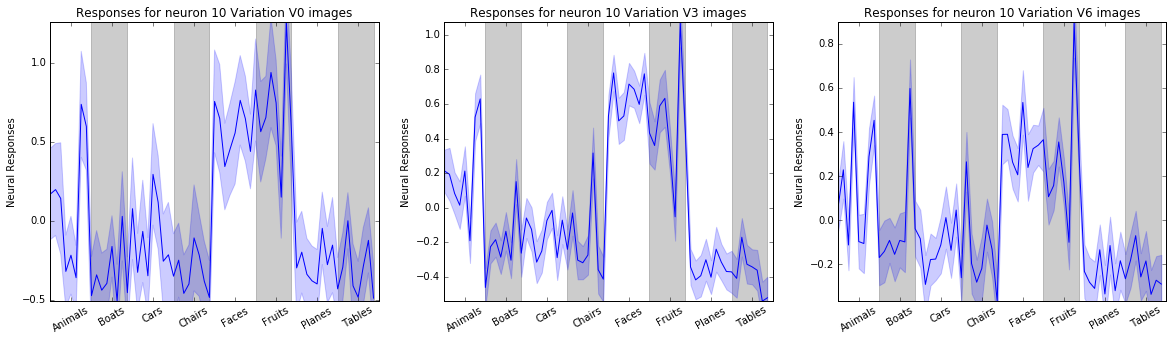

In [343]:
#Unlike our putative face neuron, this "round thing" detector is pretty consistent at high variability
#which is reasonable semantically -- round things are still round from many object angles
#but faces are really hard to recognize from extremely weird angles as seen in the high variation condition
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plot_trial_avg_data_with_stds(10, 'V0')
plt.subplot(1, 3, 2)
plot_trial_avg_data_with_stds(10, 'V3')
plt.subplot(1, 3, 3)
plot_trial_avg_data_with_stds(10, 'V6')

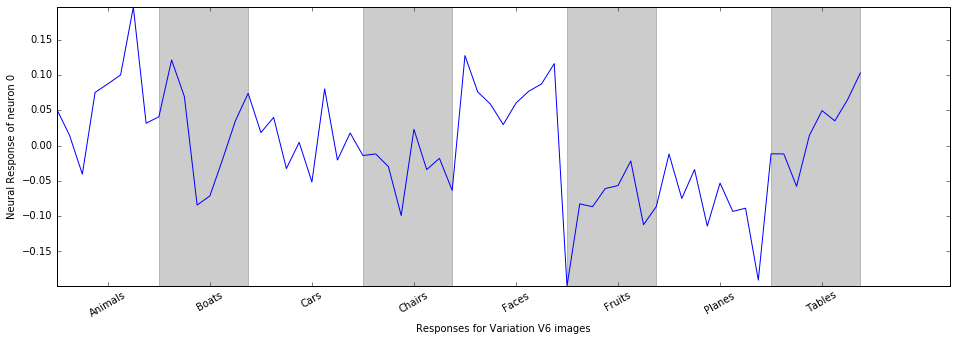

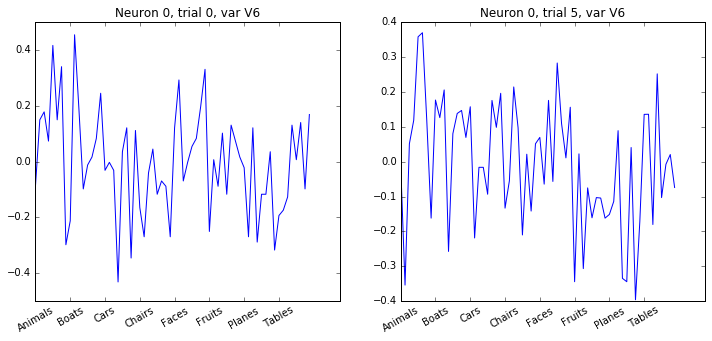

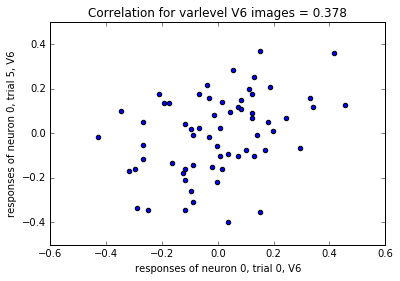

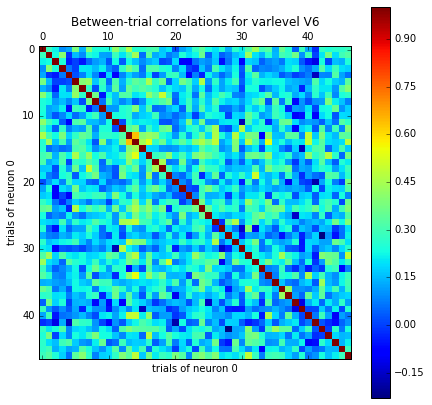

In [347]:
#neuron 0 seems to sort of be in an intermediate situation 
#-- somewhat but not incredibly reliable responses at high variation
plot_various_trial_analyses(0, 'V6')

## Split-Half Reliability

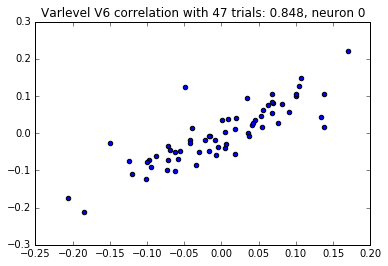

In [491]:
#but wait -- we've only really been looking at *pairs* of trials
#do we can more reliable results if we average over groups of trials?

neuron_ind = 0
vl = 'V6'
#let's measure the number of trials
num_trials = by_trial_IT_Neural_Data_objmeans_sorted_by_category[vl].shape[1]

#then compute the average of the neuron's responses in the first and second half of trials
first_half_trial_mean = by_trial_IT_Neural_Data_objmeans_sorted_by_category[vl][:, :num_trials/2, neuron_ind].mean(1)
second_half_trial_mean = by_trial_IT_Neural_Data_objmeans_sorted_by_category[vl][:, num_trials/2:, neuron_ind].mean(1)

#plot the first and second half vs each other
plt.scatter(first_half_trial_mean, second_half_trial_mean)

#.... and measure and report their correlation
corrval = stats.pearsonr(first_half_trial_mean, second_half_trial_mean)[0]
plt.title('Varlevel %s correlation with %d trials: %.3f, neuron %d' % (vl, num_trials, corrval, neuron_ind))

#much higher here with more trials

In [492]:
#here's a very simple implementation of split-half reliability
#this is a NON-boostrapping version

def get_correlation(data_by_trial, num_trials, num_splits):
    """arguments:
          data_by_trial -- (numpy array) the data
             assumes a tensor with structure is (stimuli, trials)
             
          num_trials -- (nonnegative integer) how many trials to consider
          
          num_splits (nonnegative integer) how many splits of the data to make
          
       returns:
          array of length num_splits
    """

    
    #get total number of trials
    num_total_trials = data_by_trial.shape[1]
    
    #you better not ask for more trials than you actually have
    assert num_trials <= num_total_trials, "You asked for %d trials but there's only %d" % (num_trials, num_total_trials)
    
    #we want to make sure that while we select groups of trials basically randomly,
    #that we can still exactly reproduce our results later
    #so to do this, we use a constructed random number generator to select trial groups
    #and seed the generator with seed = 0 (could be any non-negative integer, but the seed
    #*must* be set for this to be reproducible
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        #construct a new permutation of the trial indices
        perm =  random_number_generator.permutation(num_total_trials)
    
        #take the first num_trials/2 and second num_trials/2 pieces of the data
        first_half_of_trial_indices = perm[:num_trials / 2]
        second_half_of_trial_indices = perm[num_trials / 2: ]
        
        #mean over trial dimension
        mean_first_half_of_trials = data_by_trial[:, first_half_of_trial_indices].mean(1)
        mean_second_half_of_trials = data_by_trial[:, second_half_of_trial_indices].mean(1)
        
        #compute the correlation between the means
        corrval = stats.pearsonr(mean_first_half_of_trials, mean_second_half_of_trials)[0]
        #add to the list
        corrvals.append(corrval)
        
    return np.array(corrvals)

In [493]:
#to test our get_correlation function we want to work with the full IT
#not just the data averaged across all images within each object 
#so let's get a convenient data object for that

IT_Data_by_trial = {}
for vl in unique_var_levels:
    level_number = vl[-1]
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, IT_NEURONS]
    IT_Data_by_trial[vl] = arr.swapaxes(0, 1)

In [454]:
#ok so first we want to know, for a given number of trials, how many splits do we need to compute to
#get a reliable estimate of the mean tendency of the correlation with that many splits? 
#let's first look at 2 splits 

neuron_ind = 0
vl = 'V6'

num_trials = 10
num_splits = 2

corrvals = get_correlation(IT_Data_by_trial[vl][:, :, neuron_ind], 
                           num_trials, 
                           num_splits)

print(corrvals)
print('mean --> %.3f' % corrvals.mean())
print('standard error of mean --> %.3f' % (corrvals.std() / np.sqrt(num_splits)))

[ 0.43079859  0.40092748]
mean --> 0.416
standard error of mean --> 0.011


In [455]:
#... and now at 500 splits
neuron_ind = 0
vl = 'V6'

num_trials = 10
num_splits = 500

corrvals = get_correlation(IT_Data_by_trial[vl][:, :, neuron_ind], 
                           num_trials, 
                           num_splits)

print('mean --> %.3f' % corrvals.mean())
print('standard error of mean --> %.3f' % (corrvals.std() / np.sqrt(num_splits)))

mean --> 0.450
standard error of mean --> 0.001


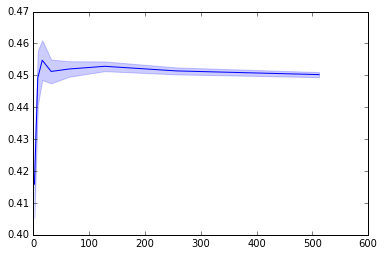

In [456]:
#in fact, let's plot reliability estimate and the SEM as a function of the number of splits
#... first for 10 trials

neuron_ind = 0
vl = 'V6'

num_trials = 10

means = []
sems = []

num_splits = [2, 8, 16, 32, 64, 128, 256, 512]
for ns in num_splits:
    cs = get_correlation(IT_Data_by_trial[vl][:, :, neuron_ind],
                           num_trials, 
                           ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)

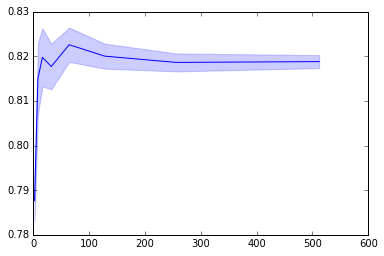

In [457]:
#... now for 25 trials
neuron_ind = 0
vl = 'V6'

num_trials = 25

means = []
sems = []

num_splits = [2, 8, 16, 32, 64, 128, 256, 512]
for ns in num_splits:
    cs = get_correlation(by_trial_IT_Neural_Data_objmeans_sorted_by_category[vl][:, :, neuron_ind], 
                           num_trials, 
                           ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)

#conclusion:  it looks like having num_splits ~ 10 * num_trials is good enough

In [495]:
#ok so now let's look at reliability as a function of number of trials

def get_reliability_curve(data):
    """
    This is a convenience function that plots reliability as a function of number of trials for some data
    
    arguments:
       data -- (numpy array) of shape (stimuli, trials)
    
    """
    means = []
    sems = []

    #determine the total number of trials
    total_num_trials = data.shape[1]
    
    #we'll evaluate reliability for each number of trials betwee 2 and the total, in intervals of 3
    num_trials = range(2, total_num_trials, 3)
    for nt in num_trials:
        ns = 10 * nt
        cs = get_correlation(data,
                               nt, 
                               ns)
        mean = cs.mean()
        means.append(mean)
        sem = cs.std() / np.sqrt(ns)
        sems.append(sem)

    means = np.array(means)
    sems = np.array(sems)

    ln = plt.plot(num_trials, means)[0]  #this "ln" thing is a matplotlib thing -- usefor for making legens (see below)
    plt.fill_between(num_trials, means - sems, means + sems, color='b', alpha = 0.2)

    plt.xlabel('Number of Trials')
    plt.ylabel('Mean correlation')
    
    return ln

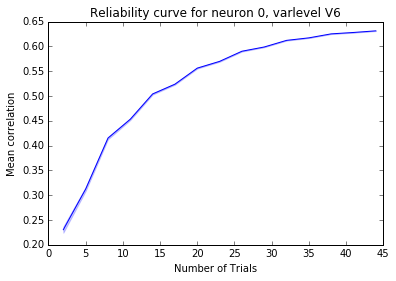

In [474]:
#so we see that, not unexpectedly, reliability increases at a function of number of trials

neuron_ind = 0
vl = 'V6'
get_reliability_curve(IT_Data_by_trial[vl][:, :, neuron_ind]);

plt.title('Reliability curve for neuron %d, varlevel %s' % (neuron_ind, vl))


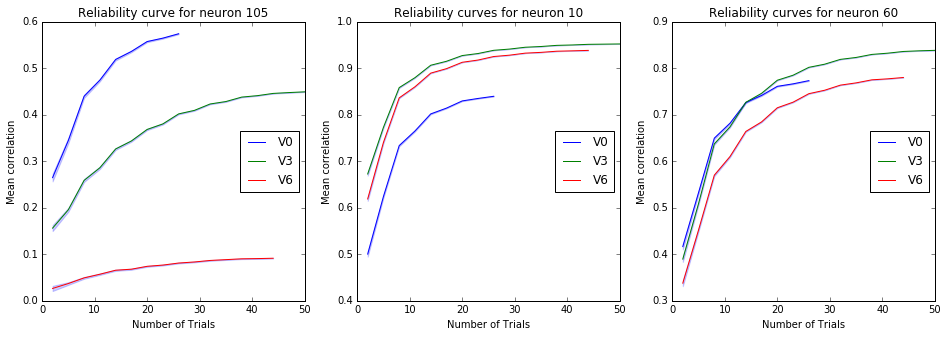

In [481]:
#but what is interesting is that reliability is different across different variation levels
#and the pattern between this is different for different neurons

plt.figure(figsize = (16, 5))

plt.subplot(1, 3, 1)
neuron_ind = 105

lns = []
for vl in unique_var_levels:
    ln = get_reliability_curve(IT_Data_by_trial[vl][:, :, neuron_ind])
    lns.append(ln)

plt.title('Reliability curve for neuron %d' % neuron_ind)
plt.legend(lns, unique_var_levels, loc='center right')

plt.subplot(1, 3, 2)
neuron_ind = 10
lns = []
for vl in unique_var_levels:
    ln = get_reliability_curve(IT_Data_by_trial[vl][:, :, neuron_ind])
    lns.append(ln)

plt.title('Reliability curves for neuron %d' % neuron_ind)
plt.legend(lns, unique_var_levels, loc='center right')


plt.subplot(1, 3, 3)
neuron_ind = 60
lns = []
for vl in unique_var_levels:
    ln = get_reliability_curve(IT_Data_by_trial[vl][:, :, neuron_ind])
    lns.append(ln)

plt.title('Reliability curves for neuron %d' % neuron_ind)
plt.legend(lns, unique_var_levels, loc='center right')

## Spearman-Brown Prophecy Formula

In [498]:
def spearman_brown(uncorrected, multiple):
    numerator = multiple * uncorrected
    denominator = 1 + (multiple - 1) * uncorrected
    return numerator / denominator

In [506]:
#ok so now let's look at reliability as a function of number of trials

def get_reliability_curve_spearman_brown(data):
    """
    This is a convenience function that plots reliability as a function of number of trials for some data
    
    arguments:
       data -- (numpy array) of shape (stimuli, trials)
    
    """
    means = []
    sems = []
    corrected_means = []

    #determine the total number of trials
    total_num_trials = data.shape[1]
    
    #we'll evaluate reliability for each number of trials betwee 2 and the total, in intervals of 3
    num_trials = range(2, total_num_trials, 3)
    for nt in num_trials:
        ns = 10 * nt
        cs = get_correlation(data,
                               nt, 
                               ns)
        mean = cs.mean()
        means.append(mean)
        sem = cs.std() / np.sqrt(ns)
        sems.append(sem)
        
        multiple = total_num_trials / float(nt) #have to do "float" here since python 2.x does integer division
        corrected_mean = spearman_brown(mean, multiple) 
        corrected_means.append(corrected_mean)
        
    means = np.array(means)
    sems = np.array(sems)
    corrected_means = np.array(corrected_means)
    
    ln = plt.plot(num_trials, means)[0]  #this "ln" thing is a matplotlib thing -- usefor for making legens (see below)
    plt.fill_between(num_trials, means - sems, means + sems, color='b', alpha = 0.2)
    
    ln_cor = plt.plot(num_trials, corrected_means)[0]

    plt.xlabel('Number of Trials')
    plt.ylabel('Mean correlation')
    
    return ln, ln_cor

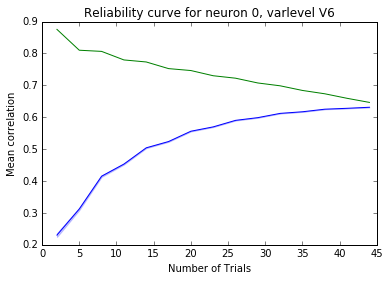

In [508]:
#ok the spearman-brown correction is a bit of an overestimate here ...
#... but not bad
neuron_ind = 0
vl = 'V6'
get_reliability_curve_spearman_brown(IT_Data_by_trial[vl][:, :, neuron_ind]);

plt.title('Reliability curve for neuron %d, varlevel %s' % (neuron_ind, vl))



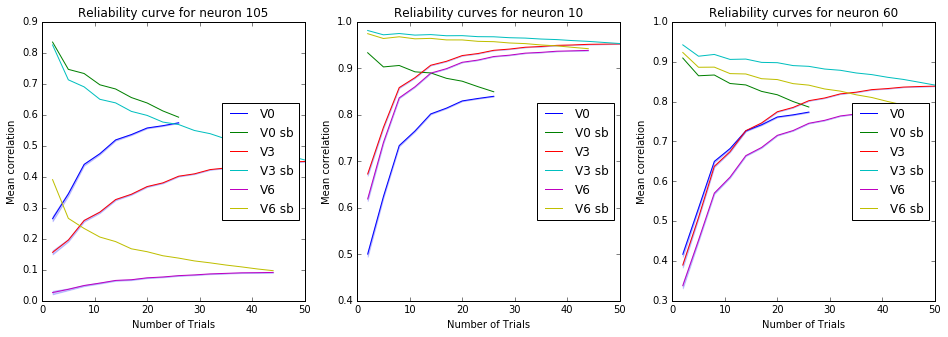

In [510]:
plt.figure(figsize = (16, 5))

plt.subplot(1, 3, 1)
neuron_ind = 105

lns = []
for vl in unique_var_levels:
    ln, ln_cor = get_reliability_curve_spearman_brown(IT_Data_by_trial[vl][:, :, neuron_ind])
    lns.extend([ln, ln_cor])

labels = ['V0', 'V0 sb', 'V3', 'V3 sb', 'V6', 'V6 sb']
plt.title('Reliability curve for neuron %d' % neuron_ind)
plt.legend(lns, labels, loc='center right')

plt.subplot(1, 3, 2)
neuron_ind = 10
lns = []
for vl in unique_var_levels:
    ln, ln_cor = get_reliability_curve_spearman_brown(IT_Data_by_trial[vl][:, :, neuron_ind])
    lns.extend([ln, ln_cor])

plt.title('Reliability curves for neuron %d' % neuron_ind)
plt.legend(lns, labels, loc='center right')


plt.subplot(1, 3, 3)
neuron_ind = 60
lns = []
for vl in unique_var_levels:
    ln, ln_cor = get_reliability_curve_spearman_brown(IT_Data_by_trial[vl][:, :, neuron_ind])
    lns.extend([ln, ln_cor])

plt.title('Reliability curves for neuron %d' % neuron_ind)
plt.legend(lns, labels, loc='center right')